# Goal-oriented risk management

Portfolio optimization toolkit with risk measures such as Value at Risk (VaR) and Conditional Value at Risk (CVaR). 



## Value at Risk (VaR) 
Statistic measuring maximum portfolio loss at a particular confidence level

Find the VaR at the 95% and 99% confidence levels, respectively, for a standard Normal distribution. 



95% VaR:  1.6448536269514722 ; 99% VaR:  2.341910593061554


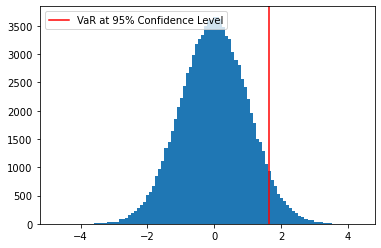

In [20]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
# Create the VaR measure at the 95% confidence level using norm.ppf()
VaR_95 = norm.ppf(0.95)

# Create the VaR meaasure at the 5% significance level using numpy.quantile()
draws = norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ",VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend(); plt.show()

# Comparing CVaR and VaR
The conditional value at risk (CVaR), or expected shortfall (ES), asks what the average loss will be, conditional upon losses exceeding some threshold at a certain confidence level. It uses VaR as a point of departure, but contains more information because it takes into consideration the tail of the loss distribution.

CVaR_95 =  2.0456763020795825


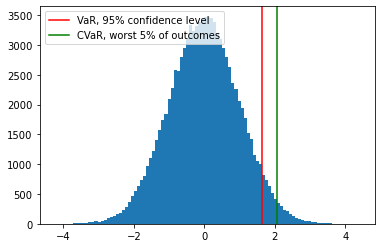

In [21]:
# Compute the mean and variance of the portfolio returns
import pandas as pd
losses = pd.Series(norm.rvs(size=10000))
pm =losses.mean()
ps = losses.std()

# Compute the 95% VaR using the .ppf()
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss
print("CVaR_95 = ", CVaR_95)
# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()

### Kernel density estimation

VaR_99 from KDE:  2.2884057877542032


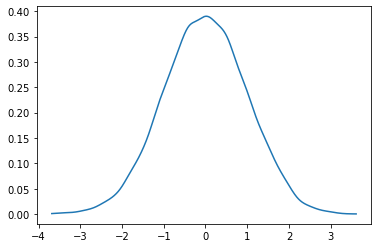

In [34]:
# KDE
from scipy.stats import gaussian_kde
kde = gaussian_kde(losses)
x = np.linspace(np.min(losses),np.max(losses), 1000)
plt.plot(x, kde.pdf(x))

# Finding VaR using KDE
sample = kde.resample(size = 1000)
VaR_99 = np.quantile(sample, 0.99)
print("VaR_99 from KDE: ", VaR_99)

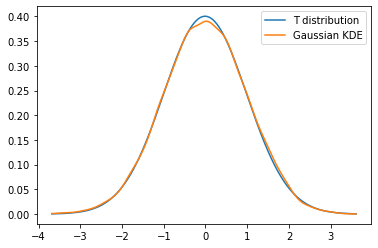

In [23]:
# Generate a fitted T distribution over losses
from scipy.stats import t
params = t.fit(losses)

# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(losses)

# Add the PDFs of both estimates to a histogram, and display
x = np.linspace(np.min(losses), np.max(losses), 1000)
plt.plot(x, t.pdf(x, *params), label = 'T distribution')
plt.plot(x, kde.pdf(x), label = 'Gaussian KDE')
plt.legend(); plt.show()

# Risk exposure and loss

 Find the VaR using another common loss distribution, the Student's t-distribution (or T) contained in scipy.stats

D:\Program\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


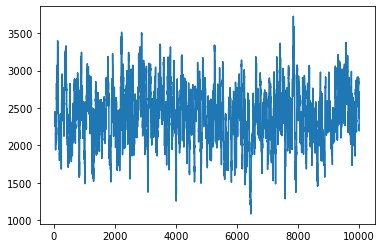

In [24]:
# Import the Student's t-distribution
from scipy.stats import t

# Create rolling window parameter list
mu = losses.rolling(30).mean()
sigma = losses.rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99,*params) 
                    for params in rolling_parameters ] )

# Plot the minimum risk exposure
plt.plot(losses.index, 0.01 * VaR_99 * 100000)
plt.show()

In [25]:
# Fit the Student's t distribution to crisis losses
p = t.fit(losses)

# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

2.6461338950066646


In [32]:
### CVaR and loss cover selection
from scipy.stats import t
params = t.fit(losses)
# Find the VaR as a quantile of random samples from the distributions
VaR_99_T   = np.quantile(t.rvs(size=1000, *params), 0.99)

# Find the expected tail losses, with lower bounds given by the VaR measures
integral_T   = t.expect(lambda x: x, args = (params[0],), loc = params[1], scale = params[2], lb = VaR_99_T )


# Create the 99% CVaR estimates
CVaR_99_T   = (1 / (1 - 0.99)) * integral_T


# Display the results
print("99% CVaR for T: ", CVaR_99_T)

99% CVaR for T:  4.740412697444935


# VaR from a fitted distribution
Minimizing CVaR requires calculating the VaR at a confidence level, say 95%. Previously you derived the VaR as a quantile from a Normal (or Gaussian) distribution, but minimizing the CVaR more generally requires computing the quantile from a distribution that best fits the data.

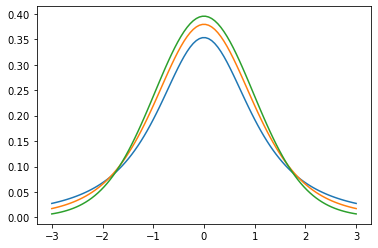

In [26]:
# Visualize the fitted distribution with a plot
from scipy import stats
x = np.linspace(-3, 3, 100)
plt.plot(x, t.pdf(x, df = 2))
plt.plot(x, t.pdf(x, df = 5))
plt.plot(x, t.pdf(x, df = 30))

In [27]:
# Create a random sample of 100,000 observations from the fitted distribution
sample = np.random.normal(-0.25,0.25,100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, 0.95)
print(VaR_95)

0.16121296548180802


# Parameter estimation
Parameter estimation is the strongest method of VaR estimation because it assumes that the loss distribution class is known. Parameters are estimated to fit data to this distribution, and statistical inference is then made.

Test Normal distribution using Anderson-Darling test. If the test result is statistically different from zero, this indicates the data is not Normally distributed. 

In [28]:
# Import the Normal distribution and skewness test from scipy.stats
from scipy.stats import norm, anderson

# Fit portfolio losses to the Normal distribution
params = norm.fit(losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print("Anderson-Darling test result: ", anderson(losses))

VaR_95, Normal distribution:  1.629074569684965
Anderson-Darling test result:  AndersonResult(statistic=0.32967358171663363, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


# Skewness

In [29]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Test the data for skewness
print("Skewtest result: ", skewtest(losses))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(losses)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=-2.0066646445557277, pvalue=0.04478538301545058)
VaR_95 from skew-normal:  1.6290743481769103
